In [7]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from sklearn.metrics import (
    confusion_matrix, roc_auc_score, f1_score,
    classification_report, recall_score, roc_curve
)
import lightgbm as lgb

In [4]:
from google.colab import files
uploaded = files.upload()

Saving diabetes (1).csv to diabetes (1).csv


In [6]:
# loading the diabetes dataset to a pandas DataFrame
diabetes_dataset = pd.read_csv("diabetes (1).csv")

In [ ]:
diabetes_dataset.head()


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


Data Cleaning and Imputation

In [8]:
# Replace zero values with NaN for specific columns (since 0 isn't a valid medical value)
zero_not_accepted = ['Glucose', 'BloodPressure', 'SkinThickness', 'BMI', 'Insulin']
for column in zero_not_accepted:
    diabetes_dataset[column] = diabetes_dataset[column].replace(0, np.nan)
    # Fill missing values with column mean
    diabetes_dataset[column] = diabetes_dataset[column].fillna(diabetes_dataset[column].mean())


Feature and Target Separation

In [9]:
# Define feature variables (X) and target variable (y)
X = diabetes_dataset.drop(columns='Outcome')  # Features
y = diabetes_dataset['Outcome']              # Target: 1 = Diabetic, 0 = Non-diabetic


Train-Test Split

In [10]:
# Split the data into training and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


Feature Scaling

In [11]:
# Standardize the features using StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


Handle Class Imbalance using SMOTE

In [12]:
# Apply SMOTE to balance the classes in the training data
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)


Random Forest Classifier + Hyperparameter Tuning

In [13]:
# Initialize RandomForestClassifier
rf_classifier = RandomForestClassifier(random_state=42)

# Define hyperparameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}

# Grid search with 5-fold cross-validation, optimizing for recall
grid_search = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, cv=5, scoring='recall')
grid_search.fit(X_train_resampled, y_train_resampled)

# Get the best model from grid search
best_rf_classifier = grid_search.best_estimator_


Predict Probabilities and Tune Threshold

In [14]:
# Predict probabilities on test set
y_pred_proba = best_rf_classifier.predict_proba(X_test)[:, 1]

# Calculate ROC curve to find best threshold
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]

# Apply optimal threshold
y_pred = (y_pred_proba >= optimal_threshold).astype(int)


Model Evaluation

In [15]:
# Evaluate using confusion matrix, classification report, ROC AUC, F1, and recall
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print(f"ROC AUC Score: {roc_auc_score(y_test, y_pred_proba):.4f}")
print(f"F1 Score: {f1_score(y_test, y_pred):.4f}")
print(f"Recall: {recall_score(y_test, y_pred):.4f}")


Confusion Matrix:
 [[77 22]
 [13 42]]

Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.78      0.81        99
           1       0.66      0.76      0.71        55

    accuracy                           0.77       154
   macro avg       0.76      0.77      0.76       154
weighted avg       0.78      0.77      0.78       154

ROC AUC Score: 0.8197
F1 Score: 0.7059
Recall: 0.7636


Feature Importance from Random Forest
Random Forest provides a built-in feature importance method based on how much each feature decreases impurity (e.g., Gini).

/tmp/ipython-input-16-1602199860.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')


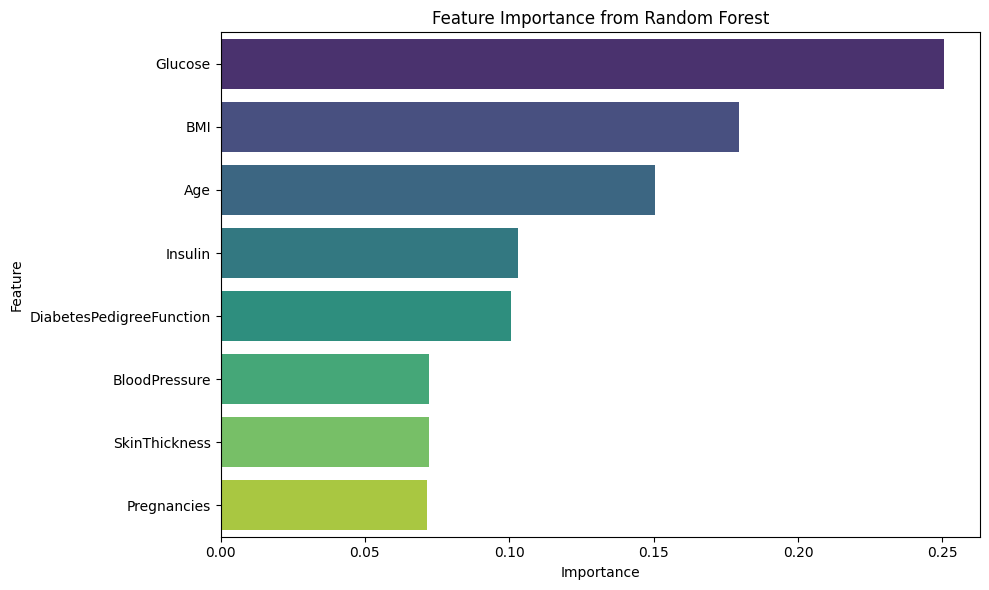

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

# Get feature importances from trained best RF model
importances = best_rf_classifier.feature_importances_
feature_names = diabetes_dataset.drop(columns='Outcome').columns

# Create a DataFrame for plotting
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')
plt.title('Feature Importance from Random Forest')
plt.tight_layout()
plt.show()


Visualize Glucose Distribution by Outcome
This gives an intuitive picture of how glucose varies in diabetics vs non-diabetics.

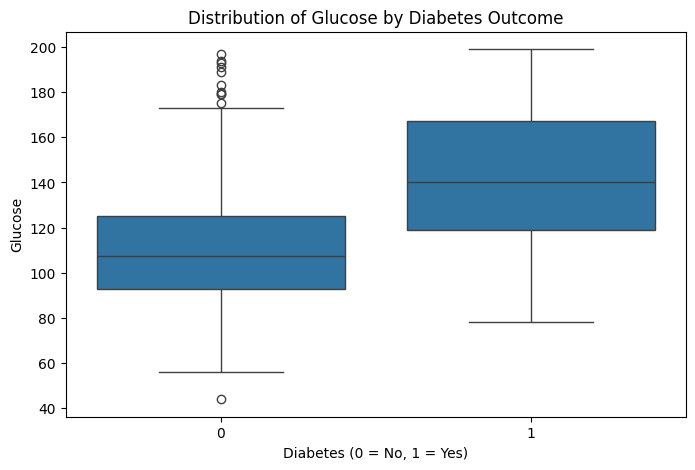

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
sns.boxplot(x='Outcome', y='Glucose', data=diabetes_dataset)
plt.title("Distribution of Glucose by Diabetes Outcome")
plt.xlabel("Diabetes (0 = No, 1 = Yes)")
plt.ylabel("Glucose")
plt.show()
